# Prediction Pipeline: 
- Use the previously trained Regressor Models for History Construction (Pol, Brix or Purity).  
- Perform the Curve fitting for Forecasting Future Values of Pol, Brix or Purity.

The purpose is to use the regressor model for constructing the Pol, Brix or Purity history of any IDCOMP. Based on this history create a specific curve fit by IDCOMP, with a secuential variable called IMG.

The Input consists of:
- An Optimization Date.
- An IDCOMP (ID of an specific lot).
- Target Variable (Pol, Brix or Purity)
- Country (GT or NI).

The Output consists of:
- Predictions for the Pol, Brix or Purity for the next 15 days after the Optimization Date (daily values).

In [78]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
import pickle
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler

import pickle

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

gv_xdata = []
gv_ydata =[]

In [79]:
# Determining the columns data types
def d_types(dataset):
    numeric_cols = []
    categoric_cols = []
    date_cols = []
    for col in dataset.columns:
        if(dataset[col].dtype == "object"):
            categoric_cols.append(col)
        elif((dataset[col].dtype == "int64") or (dataset[col].dtype == "float64")):
            numeric_cols.append(col)
        else:
            date_cols.append(col)
    return[numeric_cols,categoric_cols,date_cols]

# Frequency Encoder
def Freq_Encode(df, cols):
    encoder_dict={}
    for var in cols:
        encoder_dict[var]=(df[var].value_counts()).to_dict()
    new_data=df.copy()
    for var in cols:
        new_data[var]=new_data[var].map(encoder_dict[var]) 
    return new_data,encoder_dict

# Data standarizer
def estandarizar(df, cols, trans=0):
    dataset_new=df.copy()
    if trans==0:
        trans = StandardScaler()
        dataset_new[cols]=trans.fit_transform(dataset_new[cols])
    else:
        dataset_new[cols]=trans.fit_transform(dataset_new[cols])
        
    data_final= pd.DataFrame(data=dataset_new, index=df.index, columns= df.columns)
    return [data_final,trans]

# Use of previously trained Frequency Encoder
def Freq_Encode_predict(df, cols, encoder_dict):
    new_data=df.copy()
    var_notin=[]
    for var in cols:
        if var in encoder_dict:
            new_data[var]=new_data[var].map(encoder_dict[var])
        else:
            var_notin.append(var)
    return new_data,var_notin



In [80]:
# Function to obtain the corresponding dataset (by country, season and IDCOMP) to provide 
# the previously trained Regressor with the correct data to construct the history for Pol, Brix or Purity.
# We also impute NaN values with the corresponding Median of the feature distribution.

def getData(pPais, pZafra, pIdcomp):
    df_original = pd.read_csv("./"+pPais+"/"+pPais+"_DatosModeloBPP.csv")

    df_imp = df_original.drop(columns=['Unnamed: 0','DOSIS_PRODUCTO','FECHA_INICIO_CICLO'
                                ,'cuad_mes','PREC_ACT','ETP_ACT','Fuente'
                                ,'Jugo','Humedad','Fibra','Muestras','fecha_aplicacion','Redimiento'
                                ,'PRE_Brix','PRE_Pol','PRE_Pureza','POS_Brix','POS_Pol','POS_Pureza'])#,'Fuente'
    
    if pPais=='NI':
        df_imp['TEMP_EDAD'].fillna(df_imp['TEMP_EDAD'].median(), inplace=True)
        df_imp['RAD_EDAD'].fillna(df_imp['RAD_EDAD'].median(), inplace=True)
        df_imp['ETP15'].fillna(df_imp['ETP15'].median(), inplace=True)
        df_imp['TEMP15'].fillna(df_imp['TEMP15'].median(), inplace=True)
        df_imp['ETP1630'].fillna(df_imp['ETP1630'].median(), inplace=True)
        df_imp['TEMP1630'].fillna(df_imp['TEMP1630'].median(), inplace=True)
        df_imp['RAD1630'].fillna(df_imp['RAD1630'].median(), inplace=True)
        df_imp['ETP30'].fillna(df_imp['ETP30'].median(), inplace=True)
        df_imp['TEMP30'].fillna(df_imp['TEMP30'].median(), inplace=True)
        df_imp['RAD30'].fillna(df_imp['RAD30'].median(), inplace=True)
        df_imp['RAD15'].fillna(df_imp['RAD15'].median(), inplace=True)
        df_imp['ETP_EDAD'].fillna(df_imp['ETP_EDAD'].median(), inplace=True)
        df_imp['NDVI_POND'].fillna(df_imp['NDVI_POND'].median(), inplace=True)
        df_imp['AGUA_POND'].fillna(df_imp['AGUA_POND'].median(), inplace=True)
        df_imp['HUMEDAD_POND'].fillna(df_imp['HUMEDAD_POND'].median(), inplace=True)
        df_imp['HUMEDAD_POND30'].fillna(df_imp['HUMEDAD_POND30'].median(), inplace=True)
        df_imp['HUMEDAD_POND1630'].fillna(df_imp['HUMEDAD_POND1630'].median(), inplace=True)
        df_imp['NDVI_POND30'].fillna(df_imp['NDVI_POND30'].median(), inplace=True)
        df_imp['AGUA_POND1630'].fillna(df_imp['AGUA_POND1630'].median(), inplace=True)
        df_imp['NDVI_POND1630'].fillna(df_imp['NDVI_POND1630'].median(), inplace=True)
        df_imp['AGUA_POND30'].fillna(df_imp['AGUA_POND30'].median(), inplace=True)
        df_imp['BIOMASA_POND'].fillna(df_imp['BIOMASA_POND'].median(), inplace=True)
    else:
        df_imp['BIOMASA_POND'].fillna(df_imp['BIOMASA_POND'].median(), inplace=True)
        df_imp['HUMEDAD_POND'].fillna(df_imp['HUMEDAD_POND'].median(), inplace=True)
        df_imp['NDVI_POND'].fillna(df_imp['NDVI_POND'].median(), inplace=True)
        df_imp['AGUA_POND'].fillna(df_imp['AGUA_POND'].median(), inplace=True)
        df_imp['AGUA_POND30'].fillna(df_imp['AGUA_POND30'].median(), inplace=True)
        df_imp['NDVI_POND30'].fillna(df_imp['NDVI_POND30'].median(), inplace=True)
        df_imp['HUMEDAD_POND30'].fillna(df_imp['HUMEDAD_POND30'].median(), inplace=True)
        df_imp['HUMEDAD_POND1630'].fillna(df_imp['HUMEDAD_POND1630'].median(), inplace=True)
        df_imp['AGUA_POND1630'].fillna(df_imp['AGUA_POND1630'].median(), inplace=True)
        df_imp['NDVI_POND1630'].fillna(df_imp['NDVI_POND1630'].median(), inplace=True)
        df_imp['HUMEDAD_POND15'].fillna(df_imp['HUMEDAD_POND15'].median(), inplace=True)
        df_imp['AGUA_POND15'].fillna(df_imp['AGUA_POND15'].median(), inplace=True)
        df_imp['NDVI_POND15'].fillna(df_imp['NDVI_POND15'].median(), inplace=True)
        df_imp['HUMEDAD_EDAD'].fillna(df_imp['HUMEDAD_EDAD'].median(), inplace=True)
        df_imp['AGUA_EDAD'].fillna(df_imp['AGUA_EDAD'].median(), inplace=True)
        df_imp['NDVI_EDAD'].fillna(df_imp['NDVI_EDAD'].median(), inplace=True)
    
    return df_imp[(df_imp['IDCOMP']==pIdcomp)&(df_imp['ZAFRA']==pZafra)]

In [254]:
# Function to construct the corresponding Pol, Brix or Purity History based on the previously filtered and imputed dataset (by country, season and IDCOMP).

def createHistory(pPais, pModelo, pIdcomp, pDate):
    
    r_status = 'OK'
    
    print(f'PAIS = {pPais}')        
    print(f'MODELO = {pModelo}')        
    print(f'IDCOMP = {pIdcomp}')

    V_TARGET = pModelo
    V_IDCOMP = pIdcomp

    V_FECHA_OPTIMIZADOR = pd.to_datetime(pDate)
    V_FECHA_MIN_HISTORIA = V_FECHA_OPTIMIZADOR  - pd.DateOffset(days=75)  ## Se restan 15 imagenes hacia atras para obtener historia
    print(f'V_FECHA_OPTIMIZADOR = {V_FECHA_OPTIMIZADOR}')
    print(f'V_FECHA_MIN_HISTORIA = {V_FECHA_MIN_HISTORIA}')

    df_datos = getData(pPais, '22-23', pIdcomp)  ####  <<<==== Zafra que se desea trabajar  ***************
    df_datos['FECHA_IMG'] = pd.to_datetime(df_datos['FECHA_IMG'])

    df_idcomp = df_datos[(df_datos['FECHA_IMG']>=V_FECHA_MIN_HISTORIA)&
                         (df_datos['FECHA_IMG']<=V_FECHA_OPTIMIZADOR)].sort_values('FECHA_IMG', ascending=True).reset_index().drop(columns='index')
    
    if df_idcomp.shape[0] > 3: # check for at least 3 history points for performing the curve fitting
        
        # *****************  Load scalers, encoder & model   ************************

        scaler_x = pickle.load(open('./'+pPais+'/'+pPais+'_StandarScaler_x.pkl', 'rb'))
        codificador_cat=pickle.load(open('./'+pPais+'/'+pPais+'_Encoder_Categoric.pkl', 'rb'))
        codificador_fechas=pickle.load(open('./'+pPais+'/'+pPais+'_Encoder_Dates.pkl', 'rb'))
        colnames_order=pickle.load(open('./'+pPais+'/'+pPais+'_colnames_order.pkl', 'rb'))
        model = pickle.load(open('./'+pPais+'/'+pPais+'_Modelo'+V_TARGET+'.pkl', 'rb'))

        # ***********  Apply regressor to constructed history   ************************
        df_in_order = df_idcomp[colnames_order] # change column order.
        numeric_cols, categoric_cols, date_cols = d_types(df_in_order)
        new_data,cat_notin=Freq_Encode_predict(df_in_order, categoric_cols, codificador_cat)
        new_data,date_notin=Freq_Encode_predict(new_data, date_cols,codificador_fechas)

        dataset_ing = new_data

        data_std = estandarizar(dataset_ing, dataset_ing.columns, scaler_x)[0]
        data_std_df = pd.DataFrame(data=data_std, index=dataset_ing.index, columns= dataset_ing.columns)

        # ***************  Aplicamos el modelo para la predicción   ************************
        pred_std = model.predict(data_std_df)

        df_result = df_idcomp.drop([V_TARGET], axis=1)
        df_result[V_TARGET] = pred_std
        
        
    else:
        df_result = pd.DataFrame()
        r_status = 'FAIL: Not enough data.'
    
    return r_status, df_result # return the history if there are enough points for this IDCOMP
        

In [221]:
# Families of Curves for Fitting

def PolinomialCurve(x, a, h, k):
    return a*(x-h)**2 + k

def double_log_curve(x, A, B, a1, a2, b1, b2, k):
    return (A/(1+np.exp(a1*(b1-x))) * B/(1+np.exp(a2*(b2-x)))) + k




In [222]:
# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    
    global gv_xdata
    global gv_ydata
    
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = double_log_curve(gv_xdata, *parameterTuple)
    return np.sum((gv_ydata - val) ** 2.0)

def generate_Initial_Parameters():
    parameterBounds = []
    parameterBounds.append([-20, 0]) # search bounds for A
    parameterBounds.append([-20, 0]) # search bounds for B
    parameterBounds.append([0, 10]) # search bounds for a1
    parameterBounds.append([-10, 0]) # search bounds for a2
    parameterBounds.append([-90, 0]) # search bounds for b1
    parameterBounds.append([-80, 30]) # search bounds for b2
    parameterBounds.append([0, 150]) # search bounds for k

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x



In [250]:
# Function for Curve Fitting

def createCurve(pPais, pModelo, pIdcomp, pDate, pmaWindow):

    V_TARGET = pModelo
    r_status = 'OK'
    
    r_status, df_result = createHistory(pPais, pModelo, pIdcomp, pDate)
    
    if r_status == 'OK':
    
        # ***************  Add days in the future for forecasting  ************************
        df_pred = df_result[['IMG','FECHA_IMG',V_TARGET]].sort_values('FECHA_IMG', ascending=True)
        df_pred['IDX'] = df_pred.index -15

        xdata = df_pred['IDX']*5
        ydata = df_pred[V_TARGET]
        moving_avg = df_pred[V_TARGET].rolling(pmaWindow).mean()
        ydata = moving_avg
        xdata = xdata[(pmaWindow-1):]
        ydata = ydata[(pmaWindow-1):]
        
        min_x = min(xdata)

        # ***********  Select the Curve for the Specified Target  ************************ 

        s1 = pd.Series(range(1,16))
        xdata_pred = np.linspace(min_x,15,100)  

        if pModelo=='Pol' or pModelo=='Brix': # Pol target
            # -0.0006 < a < 0
            popt, pcov = curve_fit(PolinomialCurve, xdata, ydata,bounds=([-0.0006,-np.inf,-np.inf],[0,np.inf,np.inf]), maxfev=100000)
            show_val = 'fit: a=%5.3f, b=%5.3f, h=%5.3f' % tuple(popt)
            ydata_pred = PolinomialCurve(xdata_pred, *popt)

        elif pModelo=='Pureza' :
            
            # by default, differential_evolution completes by calling curve_fit() using parameter bounds
            global gv_xdata
            gv_xdata = xdata
            global gv_ydata
            gv_ydata = ydata
            geneticParameters = generate_Initial_Parameters()
            
            # a <0, b < 0
            fittedParameters, pcov = curve_fit(double_log_curve, xdata, ydata, geneticParameters, maxfev=1000000)
            show_val = 'fit: A=%5.3f, B=%5.3f, a1=%5.3f, a2=%5.3f, b1=%5.3f, b2=%5.3f, k=%5.3f' % tuple(fittedParameters)
            ydata_pred = double_log_curve(xdata_pred, *fittedParameters)

        else:
            r_status = 'FAIL: No valid target to predict.'
            ydata_pred = pd.DataFrame()

        # ***********  Graph the fitted curve   ************************
        if (r_status == 'OK'):
            plt.figure(figsize=(10,5))
            plt.plot(df_pred['IDX']*5, df_pred[V_TARGET], 'ro--', label='Regressor')
            plt.plot(xdata, ydata, 'bo--', label='Moving Average')
            plt.plot(xdata_pred, ydata_pred, 'ko--',label=show_val)
            #plt.plot(xdata_pred, ydata_pred)
            plt.xlim(min(xdata_pred), max(xdata_pred))
            plt.legend()
            plt.title("IDCOMP: "+str(pIdcomp) + ' -  FECHA: ' + str(pDate) )

    else:
        ydata_pred = pd.DataFrame()

        
    return r_status, ydata_pred



### Curve Fitting and Target Forecast

Possible Input values:
- Countries: 'GT' or 'NI'.
- Target: 'Pol', 'Brix' or 'Pureza'.
- IDCOMP: the ID of the specific lot.
- Date: Last date to construct the history.
- Moving Average Window: Length of time window for moving average smoothing.

Returns:
- Plot
- Status
- Forecasted values

PAIS = GT
MODELO = Pol
IDCOMP = 10059502
V_FECHA_OPTIMIZADOR = 2023-02-22 00:00:00
V_FECHA_MIN_HISTORIA = 2022-12-09 00:00:00
OK


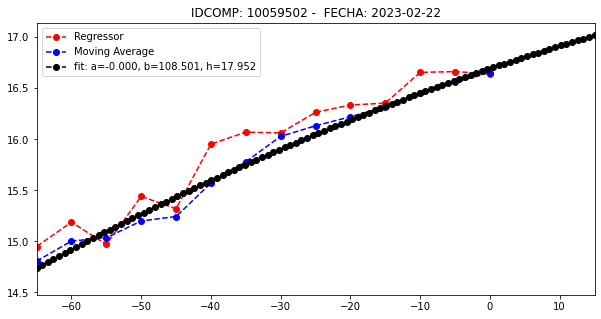

In [251]:
status, y_pred = createCurve('GT', 'Pol', 10059502, '2023-02-22', 3)
print(status)

PAIS = GT
MODELO = Brix
IDCOMP = 10059502
V_FECHA_OPTIMIZADOR = 2023-02-22 00:00:00
V_FECHA_MIN_HISTORIA = 2022-12-09 00:00:00
OK


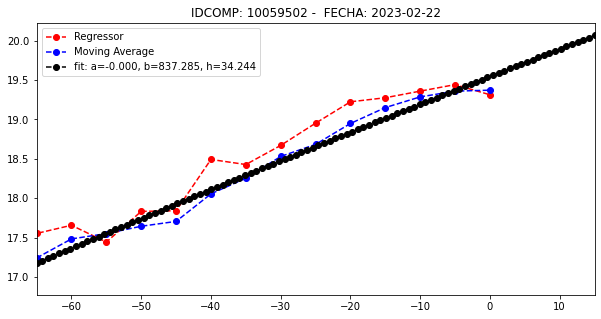

In [253]:
status, y_pred = createCurve('GT', 'Brix', 10059502, '2023-02-22', 3)
print(status)

PAIS = GT
MODELO = Pureza
IDCOMP = 10059502
V_FECHA_OPTIMIZADOR = 2023-02-22 00:00:00
V_FECHA_MIN_HISTORIA = 2022-12-09 00:00:00
OK


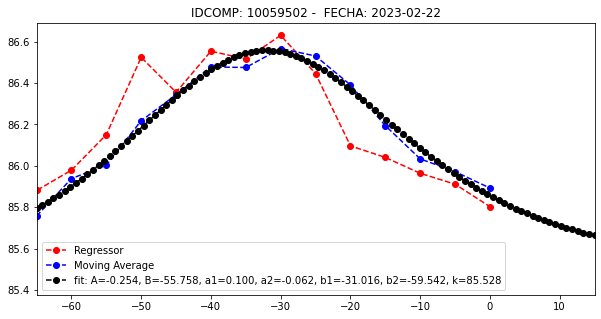

In [252]:
status, y_pred = createCurve('GT', 'Pureza', 10059502, '2023-02-22', 3)
print(status)